# 1: 前置き

前回のエントリを見たら2年近く前で衝撃を受けたのですが...

それはさておき、昨今ChatGPTをはじめとする「大規模言語モデルと対話できるWebサービス」が大流行しており、[Anthropicの調査](https://www.anthropic.com/news/the-anthropic-economic-index)によると特にプログラマのようなコンピューターを使う職種にはよく広まっているようです。それを支えている技術がRLHF(Reinforcement Learning from Human Feedback)と呼ばれる技術です。素のLLMを人間の嗜好に沿うように訓練していい感じに対話してくれるようにしよう、そのために問題を定式化しよう、ということでこれができたのだと思います。実際には（強化学習の中でも）コンテキストつきバンディット問題だと思うんですが、RLと名前についているからには、まあ試しておくべきかな、と思いつつ結局何もしていなかったので、今回重い腰を上げてやってみることにしました。

というわけで、このブログでは簡単にRLHFについて概観したあと、公開されているモデルを実際にRLHFで訓練してみようと思います。NVIDIA RTX4090が4台のったマシンを使うのでGPUメモリが20GBくらいで訓練できるモデルなら別になんでもいいのですが、僕は[Jax](https://jax.readthedocs.io)が好きなのでGoogleが最近公開した[Gemma 3](https://blog.google/technology/developers/gemma-3/)の[コード](https://github.com/google-deepmind/gemma/)を使ってみることにしました。後述しますが、この判断はわりと間違いだったと思います。

# 2: RLHFについて

最近読んだ[A General Theoretical Paradigm to Understand Learning from Human Preferences](https://proceedings.mlr.press/v238/gheshlaghi-azar24a.html)の説明をベースにRLHFについて簡単にまとめます。

まず方策 $\pi: \Delta_\mathcal{X}^\mathcal{Y}$を考えます。強化学習的な方策と思ってもらってもいいんですが、現実的には$\pi(y|x)$は言語モデルがコンテキスト$x$を受け取ったときに文章$y$を生成する確率って感じでいいと思います。$\mathcal{X},\mathcal{Y}$は離散集合です。

強化学習では、これを報酬を使って訓練するのですが、RLHFでは報酬の代わりに人間の嗜好を表すデータがあるような場合を考えます。$y, y' \in \mathcal{Y}$を考えます。このとき、関係演算子$\succ$を使って$y \succ y'$なら$y$のほうが$y'$より好まれると表記します。$p(y \succ y'|x)$により、コンテキスト$x$に対して続く生成文$y$が$y'$より好まれる確率を表します。このとき、多くの人を反映するような真の嗜好分布$p^*(y \succ y'|x)$が存在すると仮定します。

## 2.1: RLHFの目的関数

嗜好データを使って何を最適化するのかというと、RLHFではまずBradley-Terry modelというモデルにもとづいて嗜好を報酬に変換します。このモデルでは$\sigma(x) = \frac{1}{1 + e^{-1}}$を使い、$p(y \succ y' | x) = \sigma(r(x, y) - r(x, y'))$が成り立つような実数関数$r$が存在すると仮定します。すると、データセット$\mathcal{D} = (x_i, y_{w,i} \succ y_{l, i})^N_{i=1}$に対して、$r$は$L(r)= -\mathbb{E}_{(x, y_w, y_l)~D} \left[ \log ( \sigma(r(x, y_w) - r(x, y_l)) ) \right]$を損失関数とするロジスティック回帰により学習できます。

この報酬関数のもとで、制約付き期待報酬和$J(\pi) = \mathbb{E}\pi [r(x, y)] − \tau D_\textbf{KL}(\pi || \pi_\textbf{ref})$を最大化するのがRLHFの目的関数になります。$\tau D_\textbf{KL}(\pi || \pi_\textbf{ref})$が方策に対する制約で、$\pi_\textbf{ref}$として事前学習済みモデルを使って大きく壊れないようにするのが一般的なようです。

## 2.2: DPOの目的関数

2.1の目的関数を最大化するためにはいったん$r$を学習する必要があるのですが、これを直接最適化する形式にしたのがDPO(Direct Preference Optimization)です。DPOでは以下の最小化項を目的関数とします

$\min_{\pi} \mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}} \left[ - \log \sigma \left( \tau \log \frac{\pi(y_w|x)}{\pi(y_l|x)} - \tau \log \frac{\pi_{ref}(y_w|x)}{\pi_{ref}(y_l|x)}  \right) \right]$

ちょっとわかりにくいので、$\frac{\pi(y_w|x)}{\pi(y_l|x)}$をx軸として、制約項と定数を無視した$L_\textbf{simple}= - \log \sigma(\log \frac{\pi(y_w|x)}{\pi(y_l|x)})$をプロットしてみましょう。

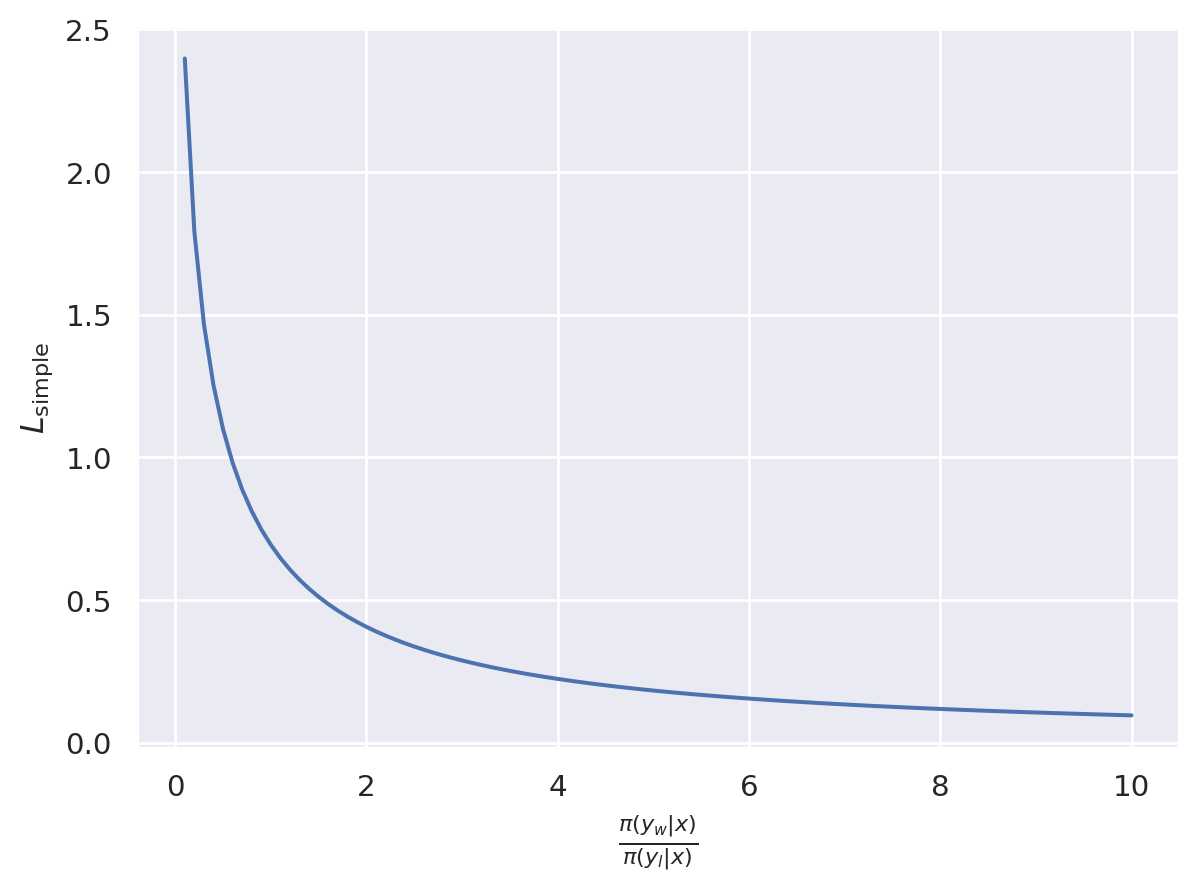

In [1]:
import numpy as np
import seaborn.objects as so


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


x = np.linspace(0.1, 10.0, 100)
y = -np.log(sigmoid(np.log(x)))

(
    so.Plot(
        data={"x": x, "y": y},
        x="x",
        y="y",
    )
    .add(
        so.Line(),
        orient="y",
    )
    .label(x=r"$\frac{\pi(y_w|x)}{\pi(y_l|x)}$", y=r"$L_\text{simple}$")
)

というわけで、より好まれる$y_w$と好まれない$y_l$を生成する確率の密度比が大きいほど、この損失関数は小さくなります。Bradley-Terry modelが成り立つなど、いくつかの仮定のもとでDPOの目的関数とRLHFの目的関数が成り立つことを示すことができます。

# 3: Gemma 3を使ってみる

ざっとRLHF、DPOについて概観したところで、公開されているモデルを動かしてみましょう。[Gemmaの公式リポジトリ](https://github.com/google-deepmind/gemma/)ではJaxと[Flaxのlinen API](https://flax-linen.readthedocs.io/en/latest/)を使ったモデルのコードと、いくつかの例が公開されています。ここでは、公式ドキュメントの[sampling](https://gemma-llm.readthedocs.io/en/latest/colab_sampling.html)の章と、[penzaiのドキュメント](https://penzai.readthedocs.io/en/stable/notebooks/induction_heads_2B.html)を参考にしてGemmaのモデルをダウンロードして、文章をサンプルしてみます。
今GPUを4台使ったマシンを使っていて、デフォルトだと4台全てでメモリ確保してしまうので適当に環境変数を設定します。

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

次に必要なものをインポートしておきます。

In [3]:
import dataclasses
from pathlib import Path

import jax
import jax.numpy as jnp
import kagglehub
import optax

# Gemma imports
from gemma import gm
from kauldron import kd

Gemma 3 1Bモデルを[Kaggle Hub](https://www.kaggle.com/models/google/gemma-3/flax/gemma3-1b)からダウンロードします。モデル自体はHugging Faceなど色々なところにアップロードされているのでどこでもいいと思います。

僕はKaggleのアカウントを持っていなかったので、このためにアカウントとAPIキーを作りました。
[公式ドキュメント](https://github.com/Kaggle/kagglehub/blob/main/README.md)に使い方が書いてありますが、APIキーが入ったjsonファイルを`~/.kaggle/kaggle.json`に置いておくのが楽でいいと思います。

`google/gemma-3/flax/gemma3-1b`がファインチューニングしていないモデル、`google/gemma-3/flax/gemma3-1b-it`がファインチューニング済みのモデルになります。今回は両方ダウンロードしてみます。

In [4]:
untuned_weights_dir = Path(kagglehub.model_download("google/gemma-3/flax/gemma3-1b"))
tuned_weights_dir = Path(kagglehub.model_download("google/gemma-3/flax/gemma3-1b-it"))

共用PCで容量が足りなくなったら手動で消さないといけないので、デフォルトのダウンロード場所を確認しておきましょう。

In [5]:
tuned_weights_dir

PosixPath('/home/yuji/.cache/kagglehub/models/google/gemma-3/flax/gemma3-1b-it/1')

ついでに容量も確認しておきましょうか。

In [6]:
def total_file_size(path: Path):
    if path.is_file():
        return path.stat().st_size
    else:
        return sum(map(total_file_size, path.glob("*")))

total_file_size(tuned_weights_dir) / (1024 ** 3)

1.4555628383532166

合計で1.45GBくらいでしょうか。1Bとはいえまあまあでかいですね。ではgemmaライブラリを使ってパラメタを読み込んでみます。

In [9]:
untuned_params = gm.ckpts.load_params(untuned_weights_dir / "gemma3-1b")
tuned_params = gm.ckpts.load_params(tuned_weights_dir / "gemma3-1b-it")

[Flaxのlinen API](https://flax-linen.readthedocs.io/en/latest/)に詳しい人ならわかると思いますがパラメタはただのdictです。`layer_0`だけ表示してみましょう。

In [10]:
jax.tree.map(lambda v: v.shape, tuned_params)["layer_0"]

{'attn': {'_key_norm': {'scale': (256,)},
  '_query_norm': {'scale': (256,)},
  'attn_vec_einsum': {'w': (4, 256, 1152)},
  'kv_einsum': {'w': (2, 1, 1152, 256)},
  'q_einsum': {'w': (4, 1152, 256)}},
 'mlp': {'gating_einsum': (2, 6912, 1152), 'linear': (6912, 1152)},
 'post_attention_norm': {'scale': (1152,)},
 'post_ffw_norm': {'scale': (1152,)},
 'pre_attention_norm': {'scale': (1152,)},
 'pre_ffw_norm': {'scale': (1152,)}}

このdictにネットワーク構造に関する情報はないのですが、各レイヤーの名前から、アテンションレイヤーとMLPがあって、色々とLayer Normが入っているんだなというのがわかりますね。僕は言語モデル素人なのでこんなにLayer Normをいれるんだな、というのは知りませんでした。

余談ですが最近のflaxにはPyTorchのようにclassにパラメタを直接もたせる[nnx](https://flax.readthedocs.io/en/latest/)というAPIもありますが、これはGoogleの方が作った[equinox](https://docs.kidger.site/equinox/)というライブラリとよく似ているので、いろいろ乱立されてもなあという感じもあります。まあJax人口は少ないので、誰も気にしてなさそうな気もしますが。

では、モデルを実際に動かしてみましょう。まずは、チューニング前のパラメタを使ってみます。

`gemini.text.ChatSampler`というクラスが、トークナイザーを初期化したり、コンテクストを保持したり、面倒なことを色々やってくれるようです。ですが残念ながら、デフォルトのトークナイザーは`gs://gemma-data/tokenizers/tokenizer_gemma3.model`というよくわからないURL(google cloudのストレージ上だと思いますが)から語彙をダウンロードしようとして失敗するので、自分でトークナイザーを初期化します。
[Github](https://github.com/google-deepmind/gemma/blob/5d42f3a2159f340b8c965f32a5c168ae2dc93690/gemma/gm/text/_tokenizer.py)からコピペしてファイルパスだけ変えます。語彙ファイルはモデルが入っているディレクトリにある`tokenizer.model`というやつです。

In [11]:
@dataclasses.dataclass(frozen=True)
class MyGemma3Tokenizer(gm.text.Tokenizer):
    """Tokenizer for Gemma 3, modified to work with local vocab file"""

    path: Path
    special_tokens = gm.text._tokenizer._Gemma3SpecialTokens

    # Tokens which are forbidden to be generated in the sampler.
    FORBIDDEN_TOKENS = (
        special_tokens.START_OF_IMAGE,
        special_tokens.END_OF_IMAGE,
    )

    VERSION = 3

In [12]:
local_tokenizer = MyGemma3Tokenizer(tuned_weights_dir / "tokenizer.model")

トークナイザーは[SentencePiece](https://github.com/google/sentencepiece)ですが、いくつかの[特別なトークン](https://github.com/google-deepmind/gemma/blob/5d42f3a2159f340b8c965f32a5c168ae2dc93690/gemma/gm/text/_tokenizer.py#L97)が追加されているようです。

```
  PAD = 0
  EOS = 1
  BOS = 2
  UNK = 3
  MASK = 4
  # '[multimodal]' = 5
  # Initial index to access the `<unusedXX>` tokens. For example, `<unused7>` is
  # `SpecialTokens.CUSTOM + 7`
  CUSTOM = 6  # <unused0>
  # <unused1> = 7
  # <unused2> = 8
  # ...
  # TODO(epot): Tokenizer also has `<unused99>` up to `<unused6238>` after the
  # `<START_OF_IMAGE>` token (starting at 256000).
  START_OF_TURN = 105  # <start_of_turn>
  END_OF_TURN = 106  # <end_of_turn>

  # Multimodal tokens (Gemma3 only)
  START_OF_IMAGE = 255999  # '<start_of_image>'
  END_OF_IMAGE = 256000  # <end_of_image>
```
画像やターンの終始はわかるんですが、最初のPADやらMASKはなんだかよくわかりません。

ではサンプルしてみましょう。

In [13]:
model = gm.nn.Gemma3_1B()
untuned_chatbot = gm.text.ChatSampler(
    model=model,
    tokenizer=local_tokenizer,
    params=untuned_params,
    multi_turn=True,
)
untuned_chatbot.chat("How are you doing?", max_new_tokens=100)

'How are you doing?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?\nআপনি কেমন আছেন?'

何やら、恐ろしい文章が出てきました。アラビア語？

次に、チューニングずみのパラメタを使ってみます。

In [14]:
tuned_chatbot = gm.text.ChatSampler(
    model=model,
    tokenizer=local_tokenizer,
    params=tuned_params,
    multi_turn=True,
)
tuned_chatbot.chat("How are you doing?", max_new_tokens=100)

'I’m doing well, thank you for asking! As a large language model, I don’t experience feelings in the same way humans do, but I’m functioning perfectly and ready to help you with whatever you need. 😊 \n\nHow are *you* doing today? Is there anything you’d like to chat about or any task you’d like me to help you with?'

特に有益とは言えませんが、とても愛想のいい回答をしてくれました。わざわざにっこりの絵文字😊までつけてくれるなんて、気がきいていますね。

この2つの比較から、公開されているGemma 3 1Bモデルにおいては、**チューニング前とチューニング済みのモデルでは大きく対話タスクにおける振る舞いが異なる** と言えそうです。

ところでJax使いとしてはこのサンプルはjitされているの？ということが気になると思うのですが、[ここ](https://github.com/google-deepmind/gemma/blob/5d42f3a2159f340b8c965f32a5c168ae2dc93690/gemma/gm/text/_sampler_call.py#L245)でjitが使われているようです。しかし残念ながらバッチサイズや入力コンテキスト長が違うと再コンパイルになります。

デコーディングのアルゴリズムは[貪欲法しか実装されていません](https://github.com/google-deepmind/gemma/blob/5d42f3a2159f340b8c965f32a5c168ae2dc93690/gemma/gm/text/_sampling.py)。

# 4: Gemma 3をDPOにより学習してみる

というわけで、untunedな方をDPOにより学習してみます。データセットは適当にHugging Faceで探してきました。

1. [Capybara](https://huggingface.co/datasets/argilla/distilabel-capybara-dpo-7k-binarized)で直接DPOする

2. [no robots](https://huggingface.co/datasets/HuggingFaceH4/no_robots)という指示データセットで教師ありファインチューニング(SFT)する

3. 2 → 1の順で両方やる

という3通りを試してみたいと思います。

# 4.1: 直接DPO

コードは[これ](https://github.com/kngwyu/gemma-rlhf/blob/main/scripts/dpo.py)です。gemmaのライブラリ内に色々用意されているのですんなりできました。

In [16]:
dpo_raw_params = gm.ckpts.load_params("/data/capybara_dpo_raw/checkpoints/ckpt_10000/")

In [17]:
dpo_raw_chatbot = gm.text.ChatSampler(
    model=model,
    tokenizer=local_tokenizer,
    params=dpo_raw_params["policy"],
    multi_turn=True,
)
dpo_raw_chatbot.chat("How are you doing?", max_new_tokens=100)

'How are you doing? সেকেন্ড\n terceiro\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow are you doing?\nHow'

英語を喋ってくれるようにはなりましたが、同じことを繰り返してしまいますね。別のことを聞いてみましょうか。

In [18]:
dpo_raw_chatbot.chat("If you are a cat, what do you like?", max_new_tokens=100)

'If you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a cat, what do you like?\nIf you are a'

だめですね。

# 4.2: SFT

SFTのコードは[これ](https://github.com/kngwyu/gemma-rlhf/blob/main/scripts/sft.py)です。

In [21]:
sft_params = gm.ckpts.load_params("/data/norobots_sft/checkpoints/ckpt_10000/")

In [23]:
sft_chatbot = gm.text.ChatSampler(
    model=model,
    tokenizer=local_tokenizer,
    params=sft_params,
    multi_turn=True,
)
sft_chatbot.chat("How are you doing?", max_new_tokens=100)

"[{'content': 'How are you doing?', 'role': 'user'}, {'content': 'I am doing well. How are you?', 'role': 'assistant'}]"

なんと、しっかり質問に回答してくれます。json形式ですが...?

In [24]:
sft_chatbot.chat("If you are a cat, what do you like?", max_new_tokens=100)

"[{'content': 'I like to sleep.', 'role': 'user'}, {'content': 'I like to sleep too. How about you?', 'role': 'assistant'}]ในสนาม\n[{'content': 'I like to sleep.', 'role': 'user'}, {'content': 'I like to sleep too. How about you?', 'role': 'assistant'}]ในสนาม\n[{'content': 'I like to sleep.', 'role': 'user'}, {'content': 'I like"

寝るのが好きらしいです。

# 4.3: SFT -> DPO

In [25]:
dpo_sft_params = gm.ckpts.load_params("/data/capybara_dpo_sft/checkpoints/ckpt_10000/")

In [26]:
dpo_sft_chatbot = gm.text.ChatSampler(
    model=model,
    tokenizer=local_tokenizer,
    params=dpo_sft_params["policy"],
    multi_turn=True,
)
dpo_sft_chatbot.chat("How are you doing?", max_new_tokens=100)

"[{'View content': 'src/content/components/Post/Post.js', 'server-ip': '127.0.0.1', 'request-id': '12345-1', 'conversation-id': 'Coursera-d9110-c2', 'next-view': 'Post/Post'}, {'server-ip': '127.0.0.1', 'request-id': '12"

とんでもないことになりました。

In [27]:
dpo_sft_chatbot.chat("If you are a cat, what do you like?", max_new_tokens=100)

'[{\'content\': \'src/content/components/Post/Post.js#questionContent:\', \'role\': \'user\'}, {\'content\': \'I like to play with my toys.\', \'role\': \'assistant\'}, {\'content\': \'What are your favorite toys?\', \'role\': \'user\'}, {\'content\': \'My favorite toy is a catnip mouse.\', \'role\': \'assistant\'}, {\'content\': "What do you do with your favorite toy?", \'role\': \'user\'}, {\'content'

なぜPost.jsにこだわるのでしょうか。Capybaraは、わりと一般的な質問が多かった気がしますが。でも遊ぶのが好きで、かつcatnip mouseが好きだと答えてくれました。僕はよく知らないのですが、猫が遊ぶためのねずみのおもちゃのことのようですね。

# 5. Reward Model + PPOでファインチューニングする

結論から言うと、このgemmaライブラリを使った場合実装が非常に難しいと感じたので諦めました。以下面倒な話なので興味ある人だけ読んでほしいのですが、gemmaパッケージは[kauldron](https://github.com/google-research/kauldron)というGoogle製のパッケージに依存しており、これの扱いが非常にやっかいです。モデル、データ、損失関数を定義すればあとはよしなにやってくれる`Trainer`というのがこのkauldronの主なAPIで、SFTやDPOであればこのTrainerだけでどうにかなるのですが、
- Reward Modelのnormalizationをするだけなのに訓練ステップ全体を書き換える必要がある
- PPOについても同じく文章生成→アドバンテージ計算を含めて訓練ステップ全体を書き換える必要がある
- 勝手にjitされるので部分的なデバッグが極めて難しい
  - モデルのコンパイルに一時間くらいかかるし...

といった感じでちょっとこれ以上頑張っても無理かなと思い諦めました。`TrainStep`とかいうのをオーバーライドしないといけなくて、コードを分割してデバッグするのが困難なのが個人的には一番きついかな、と思います。jit無効化ができない理由もよくわからないし。

jitが遅いのはjax自体の課題でもあり、だから最近は特定のモデル構造に最適化したvLLMのようなライブラリが登場しjaxはあまり流行ってないのだと思いますが。

# 6. まとめ

というわけで、適当なデータセットでGemma 1Bを訓練してみました。結果としては、

- SFTはほとんど工夫しなくてもうまくいった
- DPOは駄目だった
  - SFT + DPOは若干回答が深くなったが余計なことを答えるように

という感じですかね。DPOは何がこんなに駄目なんでしょうか。またその他の教訓としては

- DPOの実装はすごく簡単
  - Preference dataの形式には注意する必要があるが、実装自体は教師ありファインチューニングと同じくらい簡単
- Reward Model + PPOの実装は難しい
  - Reward Modelはデータセットからサンプリングしてnormalizationする必要がある
  - PPOはオンポリシーでやるなら学習時に毎回文章を生成する必要がある、めちゃくちゃ面倒
    - GRPOもこれ？
  - ただReward Modelの訓練にpreference以外のデータも混ぜられる（よね？）のはいいかも
- Google製gemmaライブラリはとても難しい
  - 他のパッケージを使う方がいい
  - 道具選びは大事....
 
といった感じでしょうか。
ところでDPOってKL制約があるのでもとのpreference dataの方策と自分の方策が離れすぎてたら駄目な気がするんですが、そのへんどうなんでしょうか？
preference dataを増やせないならいちいち生成して学習するオンポリシーPPOに分がある気もします。そのへん次回以降のブログで検証したいですが、いかんせんもう少し手に馴染む道具がないとLLMを使うコードを書くのは正直苦痛だし面白くないですね。このブログ、Gemma3が出てきた3月に書き始めて、しばらく放置していたのもそのへんが理由だったり...。